# 02 - Cleanup & EDA

This notebook covers:
1. Loading enriched ratings data
2. Data cleanup
3. Exploratory Data Analysis for Group Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Custom Color Palettes

# Gradient for Heatmaps (Coral -> Light Gray -> Teal)
HEATMAP_COLORS = ['#EF5350', '#F0F0F0', '#008080']
heatmap_cmap = LinearSegmentedColormap.from_list('coral_teal', HEATMAP_COLORS)

# General 5-color palette
PALETTE_5 = ['#008080', '#40B0A0', '#FFA500', '#696969', '#F0E68C']
# Teal Base, Verde Azulado Claro, Naranja Cálido, Gris Neutro, Amarillo Suave

# 4-color triadic palette
PALETTE_4 = ['#00A9A5', '#A500AA', '#AAA500', '#1E4E79']
# Teal Brillante, Magenta Suave, Amarillo Dorado, Azul Profundo

# 6-color soft contrast palette
PALETTE_6 = ['#1A8C84', '#F46045', '#4C72B0', '#B8B8E8', '#6B8E23', '#FFFDD0']
# Teal Apagado, Coral Suave, Azul Claro, Lavanda, Verde Musgo, Crema

# 3-color professional palette
PALETTE_3 = ['#006D77', '#E29578', '#EDF6F9']
# Teal Profundo, Rojo Ladrillo, Blanco Roto

# 7-color marine palette
PALETTE_7 = ['#03A9F4', '#01579B', '#B2DFDB', '#546E7A', '#7986CB', '#FFEB3B', '#00BCD4']
# Aqua Brillante, Azul Oscuro, Verde Menta, Gris Pizarra, Púrpura Suave, Amarillo Limón, Cian Brillante

# Set default palette
sns.set_palette(PALETTE_5)

In [3]:
# Define paths
DATA_PROCESSED = Path('../data/processed')

## Load Data

In [4]:
# Load enriched ratings
df = pd.read_csv(DATA_PROCESSED / 'ratings_enriched.csv')

print(f"Loaded {len(df):,} rows")
print(f"\nColumns ({len(df.columns)}):")
print(list(df.columns))

Loaded 100,836 rows

Columns (21):
['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'tmdbId', 'director', 'cast', 'country', 'runtime', 'budget', 'revenue', 'release_date', 'original_language', 'vote_average', 'vote_count', 'popularity', 'tagline', 'overview', 'tags']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   userId             100836 non-null  int64  
 1   movieId            100836 non-null  int64  
 2   rating             100836 non-null  float64
 3   timestamp          100836 non-null  int64  
 4   title              100823 non-null  object 
 5   genres             100823 non-null  object 
 6   tmdbId             100823 non-null  float64
 7   director           100511 non-null  object 
 8   cast               100448 non-null  object 
 9   country            100423 non-null  object 
 10  runtime            100515 non-null  float64
 11  budget             100515 non-null  float64
 12  revenue            100515 non-null  float64
 13  release_date       100515 non-null  object 
 14  original_language  100515 non-null  object 
 15  vote_average       100515 non-null  float64
 16  vo

## Data Cleanup

In [6]:
# Check missing data before cleanup
print("Before cleanup:")
print(f"Total rows: {len(df):,}")
print(f"\nMissing director: {df['director'].isna().sum():,}")
print(f"Missing cast: {df['cast'].isna().sum():,}")

Before cleanup:
Total rows: 100,836

Missing director: 325
Missing cast: 388


In [7]:
# Remove ID columns
# Keep userId and movieId (needed for recommendations)
# Only drop external IDs
id_columns = ['imdbId', 'tmdbId']
columns_to_drop = [col for col in id_columns if col in df.columns]
df = df.drop(columns=columns_to_drop)

# Remove non-essential columns
other_columns = ['timestamp', 'tagline', 'overview']
columns_to_drop = [col for col in other_columns if col in df.columns]
df = df.drop(columns=columns_to_drop)

# Remove rows with missing critical data
rows_before = len(df)
df = df.dropna(subset=['director', 'cast', 'country', 'runtime', 'budget', 
                        'revenue', 'release_date', 'original_language', 
                        'vote_average', 'vote_count', 'popularity']).copy()
rows_after = len(df)

# Remove years from titles
df['title'] = df['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)

print(f"Rows: {rows_before:,} → {rows_after:,} (removed {rows_before - rows_after:,})")
print(f"Columns: {len(df.columns)}")

Rows: 100,836 → 100,357 (removed 479)
Columns: 17


In [8]:
# Save cleaned data
output_path = DATA_PROCESSED / 'ratings_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")

Saved to: ../data/processed/ratings_cleaned.csv


---

## Exploratory Data Analysis

Focus on features relevant for **group movie recommendation**:
- Rating patterns (what makes users agree/disagree?)
- Movie characteristics (what predicts ratings?)
- User behavior (diversity of preferences)

### Dataset Overview

In [9]:
# Basic statistics
n_ratings = len(df)
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()  # Fixed: use movieId instead of title
n_directors = df['director'].nunique()

print(f"Total ratings: {n_ratings:,}")
print(f"Unique users: {n_users:,}")
print(f"Unique movies: {n_movies:,}")
print(f"Unique directors: {n_directors:,}")
print(f"\nAvg ratings per user: {n_ratings/n_users:.1f}")
print(f"Avg ratings per movie: {n_ratings/n_movies:.1f}")

Total ratings: 100,357
Unique users: 610
Unique movies: 9,514
Unique directors: 3,922

Avg ratings per user: 164.5
Avg ratings per movie: 10.5


### 1. Rating Distribution

Understanding rating patterns is crucial for predicting group satisfaction.

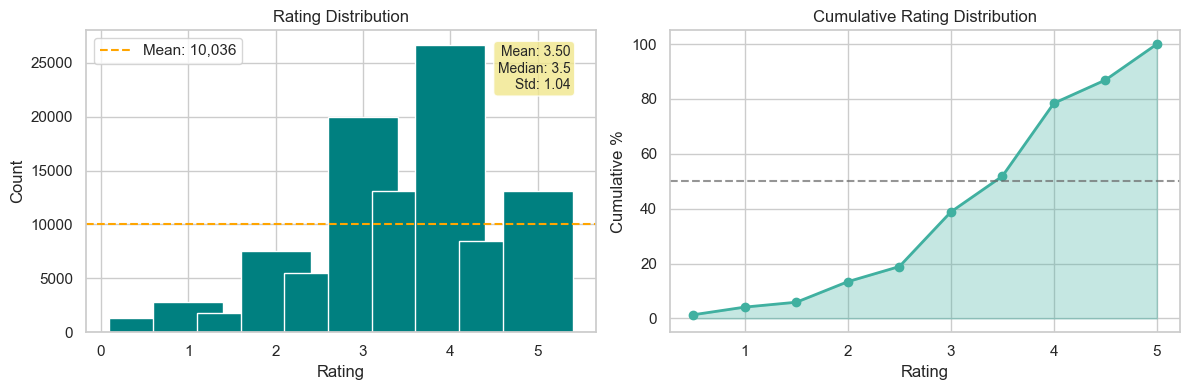


Key insight: 61.2% of ratings are 3.5 or higher (positive)


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rating distribution
rating_counts = df['rating'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color=PALETTE_5[0], edgecolor='white')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Rating Distribution')
axes[0].axhline(y=rating_counts.mean(), color=PALETTE_5[2], linestyle='--', label=f'Mean: {rating_counts.mean():,.0f}')
axes[0].legend()

# Rating statistics
stats_text = f"Mean: {df['rating'].mean():.2f}\nMedian: {df['rating'].median():.1f}\nStd: {df['rating'].std():.2f}"
axes[0].text(0.95, 0.95, stats_text, transform=axes[0].transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor=PALETTE_5[4], alpha=0.8))

# Cumulative distribution
rating_cumsum = rating_counts.cumsum() / rating_counts.sum() * 100
axes[1].plot(rating_cumsum.index, rating_cumsum.values, marker='o', color=PALETTE_5[1], linewidth=2)
axes[1].fill_between(rating_cumsum.index, rating_cumsum.values, alpha=0.3, color=PALETTE_5[1])
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Cumulative %')
axes[1].set_title('Cumulative Rating Distribution')
axes[1].axhline(y=50, color=PALETTE_5[3], linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nKey insight: {(df['rating'] >= 3.5).mean()*100:.1f}% of ratings are 3.5 or higher (positive)")

### 2. User Behavior Analysis

For group recommendations, we need to understand user diversity and rating patterns.

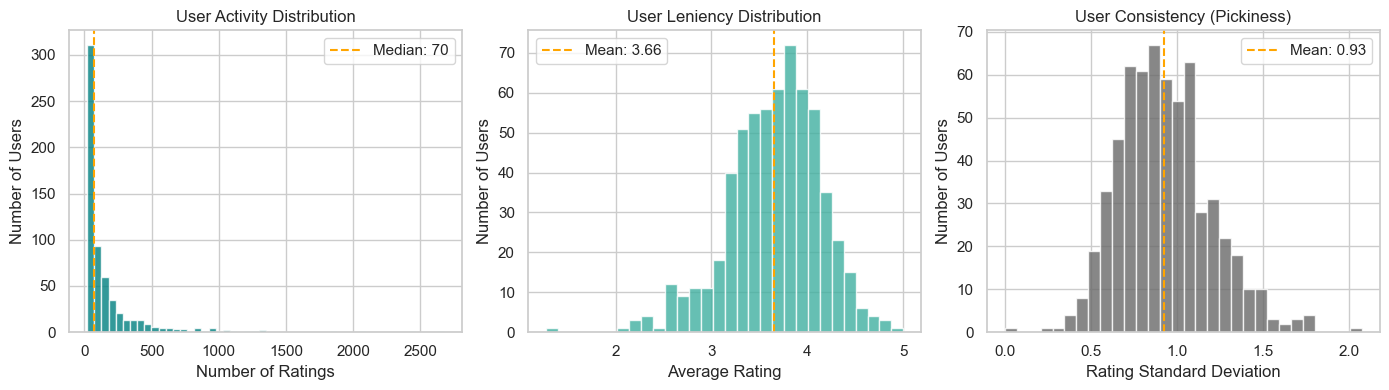


User types for group recommendations:
- Lenient users (avg > 4.0): 143 (23.4%)
- Critical users (avg < 3.0): 49 (8.0%)
- Consistent users (std < 0.8): 207 (33.9%)


In [11]:
# User activity statistics
user_stats = df.groupby('userId').agg(
    n_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std')
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Ratings per user
axes[0].hist(user_stats['n_ratings'], bins=50, color=PALETTE_5[0], edgecolor='white', alpha=0.8)
axes[0].axvline(user_stats['n_ratings'].median(), color=PALETTE_5[2], linestyle='--', 
                label=f'Median: {user_stats["n_ratings"].median():.0f}')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Activity Distribution')
axes[0].legend()

# Average rating per user
axes[1].hist(user_stats['avg_rating'], bins=30, color=PALETTE_5[1], edgecolor='white', alpha=0.8)
axes[1].axvline(user_stats['avg_rating'].mean(), color=PALETTE_5[2], linestyle='--',
                label=f'Mean: {user_stats["avg_rating"].mean():.2f}')
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('User Leniency Distribution')
axes[1].legend()

# Rating std per user (pickiness)
axes[2].hist(user_stats['std_rating'].dropna(), bins=30, color=PALETTE_5[3], edgecolor='white', alpha=0.8)
axes[2].axvline(user_stats['std_rating'].mean(), color=PALETTE_5[2], linestyle='--',
                label=f'Mean: {user_stats["std_rating"].mean():.2f}')
axes[2].set_xlabel('Rating Standard Deviation')
axes[2].set_ylabel('Number of Users')
axes[2].set_title('User Consistency (Pickiness)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nUser types for group recommendations:")
print(f"- Lenient users (avg > 4.0): {(user_stats['avg_rating'] > 4.0).sum()} ({(user_stats['avg_rating'] > 4.0).mean()*100:.1f}%)")
print(f"- Critical users (avg < 3.0): {(user_stats['avg_rating'] < 3.0).sum()} ({(user_stats['avg_rating'] < 3.0).mean()*100:.1f}%)")
print(f"- Consistent users (std < 0.8): {(user_stats['std_rating'] < 0.8).sum()} ({(user_stats['std_rating'] < 0.8).mean()*100:.1f}%)")

### 3. Movie Characteristics

Analyzing features that correlate with ratings.

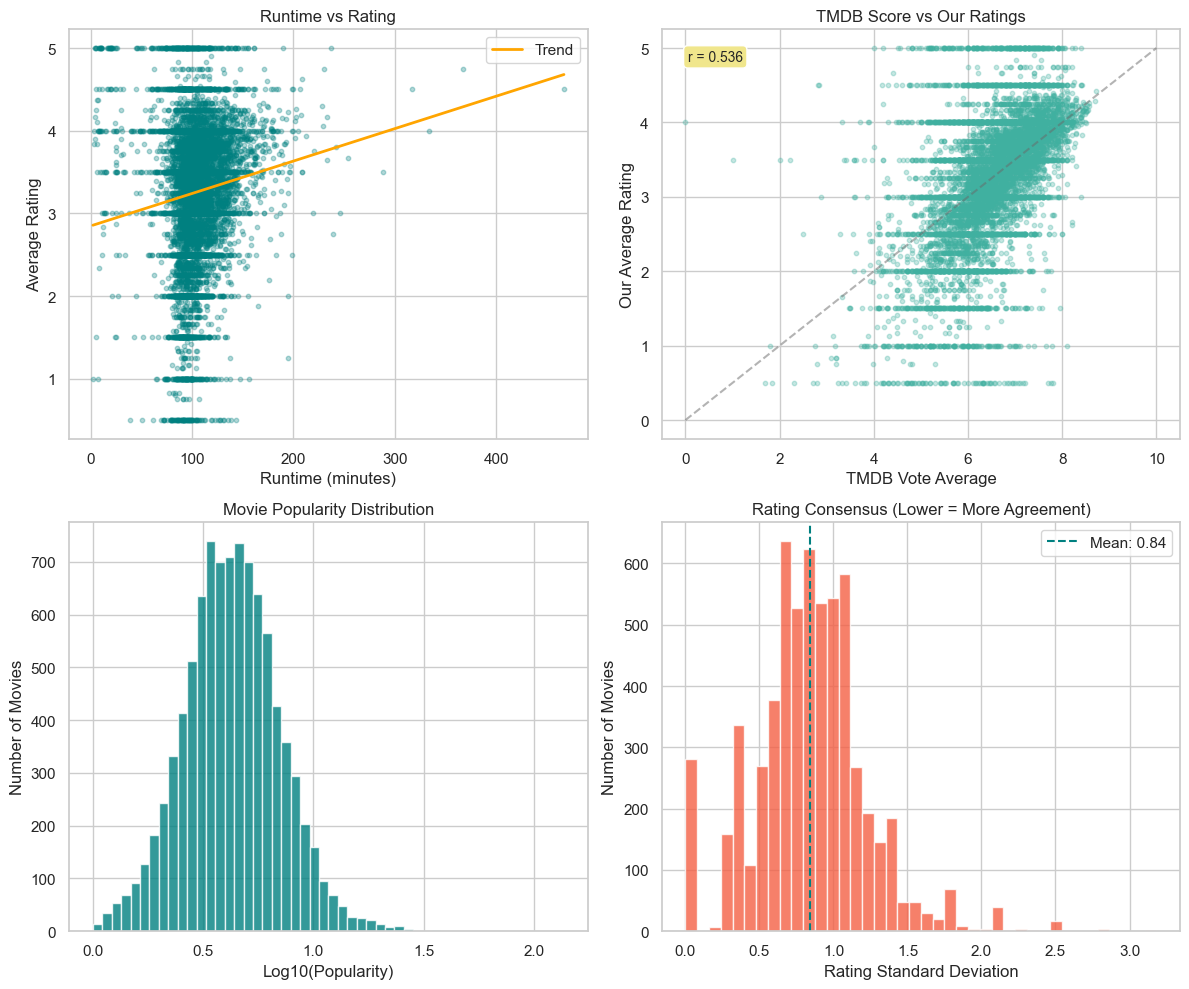


Key insight for group recs:
- High consensus movies (std < 0.8): 2720 - safer choices
- Divisive movies (std > 1.2): 804 - risk of misery


In [12]:
# Movie-level statistics
movie_stats = df.groupby('title').agg(
    n_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    runtime=('runtime', 'first'),
    vote_average=('vote_average', 'first'),
    popularity=('popularity', 'first'),
    budget=('budget', 'first'),
    revenue=('revenue', 'first')
).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Runtime vs Rating
axes[0, 0].scatter(movie_stats['runtime'], movie_stats['avg_rating'], 
                   alpha=0.3, s=10, color=PALETTE_5[0])
axes[0, 0].set_xlabel('Runtime (minutes)')
axes[0, 0].set_ylabel('Average Rating')
axes[0, 0].set_title('Runtime vs Rating')
# Add trend line
z = np.polyfit(movie_stats['runtime'].dropna(), movie_stats['avg_rating'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(movie_stats['runtime'].min(), movie_stats['runtime'].max(), 100)
axes[0, 0].plot(x_line, p(x_line), color=PALETTE_5[2], linewidth=2, label='Trend')
axes[0, 0].legend()

# TMDB Vote Average vs Our Rating
axes[0, 1].scatter(movie_stats['vote_average'], movie_stats['avg_rating'],
                   alpha=0.3, s=10, color=PALETTE_5[1])
axes[0, 1].set_xlabel('TMDB Vote Average')
axes[0, 1].set_ylabel('Our Average Rating')
axes[0, 1].set_title('TMDB Score vs Our Ratings')
# Diagonal line (perfect correlation)
axes[0, 1].plot([0, 10], [0, 5], color=PALETTE_5[3], linestyle='--', alpha=0.5, label='Perfect corr (scaled)')
corr = movie_stats['vote_average'].corr(movie_stats['avg_rating'])
axes[0, 1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0, 1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor=PALETTE_5[4]))

# Popularity distribution
axes[1, 0].hist(np.log10(movie_stats['popularity'] + 1), bins=50, 
                color=PALETTE_5[0], edgecolor='white', alpha=0.8)
axes[1, 0].set_xlabel('Log10(Popularity)')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_title('Movie Popularity Distribution')

# Rating variance (consensus indicator for group recs)
axes[1, 1].hist(movie_stats['std_rating'].dropna(), bins=40, 
                color=PALETTE_6[1], edgecolor='white', alpha=0.8)
axes[1, 1].axvline(movie_stats['std_rating'].mean(), color=PALETTE_5[0], linestyle='--',
                   label=f'Mean: {movie_stats["std_rating"].mean():.2f}')
axes[1, 1].set_xlabel('Rating Standard Deviation')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].set_title('Rating Consensus (Lower = More Agreement)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nKey insight for group recs:")
print(f"- High consensus movies (std < 0.8): {(movie_stats['std_rating'] < 0.8).sum()} - safer choices")
print(f"- Divisive movies (std > 1.2): {(movie_stats['std_rating'] > 1.2).sum()} - risk of misery")

### 4. Genre Analysis

Genres are key for diversity in group recommendations.

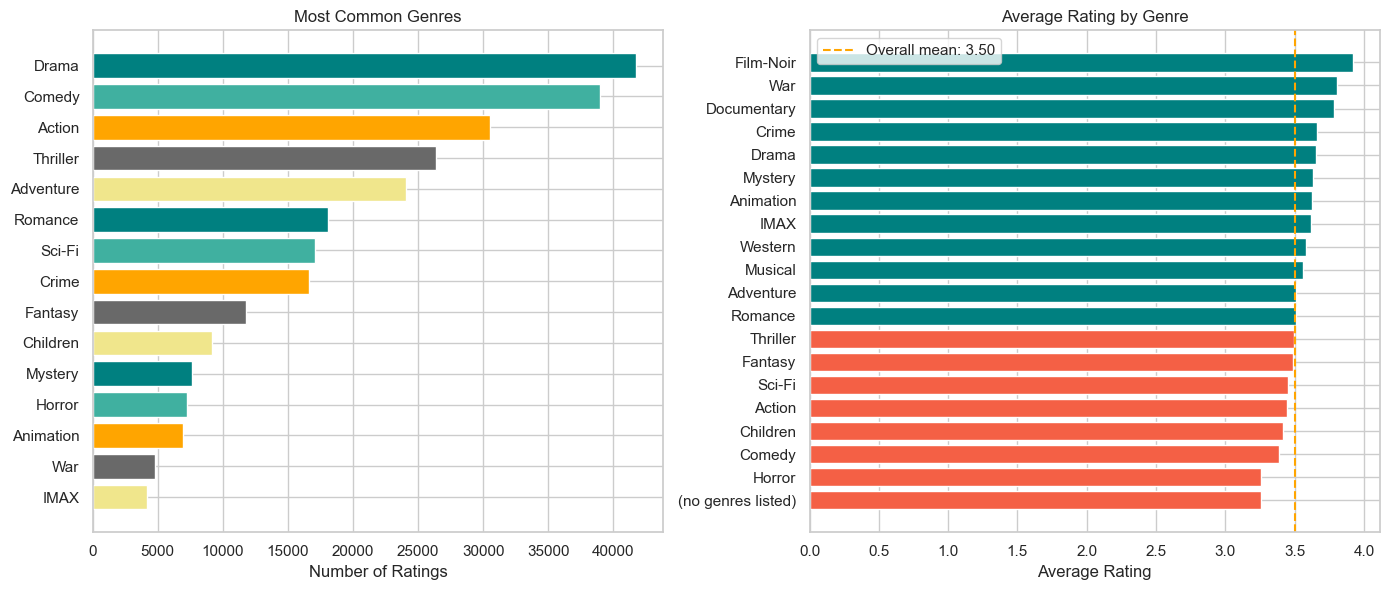


Best rated genres: Film-Noir, War, Documentary
Most divisive genres: (no genres listed), Horror, Sci-Fi


In [13]:
# Explode genres (pipe-separated)
df_genres = df.copy()
df_genres['genre_list'] = df_genres['genres'].str.split('|')
df_exploded = df_genres.explode('genre_list')

# Genre statistics
genre_stats = df_exploded.groupby('genre_list').agg(
    count=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std')
).reset_index().sort_values('count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre popularity
top_genres = genre_stats.head(15)
colors = [PALETTE_5[i % len(PALETTE_5)] for i in range(len(top_genres))]
bars = axes[0].barh(top_genres['genre_list'], top_genres['count'], color=colors, edgecolor='white')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_title('Most Common Genres')
axes[0].invert_yaxis()

# Genre ratings
genre_sorted = genre_stats.sort_values('avg_rating', ascending=True)
colors_rating = [PALETTE_6[1] if r < 3.5 else PALETTE_5[0] for r in genre_sorted['avg_rating']]
axes[1].barh(genre_sorted['genre_list'], genre_sorted['avg_rating'], 
             color=colors_rating, edgecolor='white')
axes[1].axvline(x=df['rating'].mean(), color=PALETTE_5[2], linestyle='--', 
                label=f'Overall mean: {df["rating"].mean():.2f}')
axes[1].set_xlabel('Average Rating')
axes[1].set_title('Average Rating by Genre')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nBest rated genres: {', '.join(genre_stats.nlargest(3, 'avg_rating')['genre_list'].tolist())}")
print(f"Most divisive genres: {', '.join(genre_stats.nlargest(3, 'std_rating')['genre_list'].tolist())}")

### 5. Director Impact

Directors significantly influence movie quality perception.

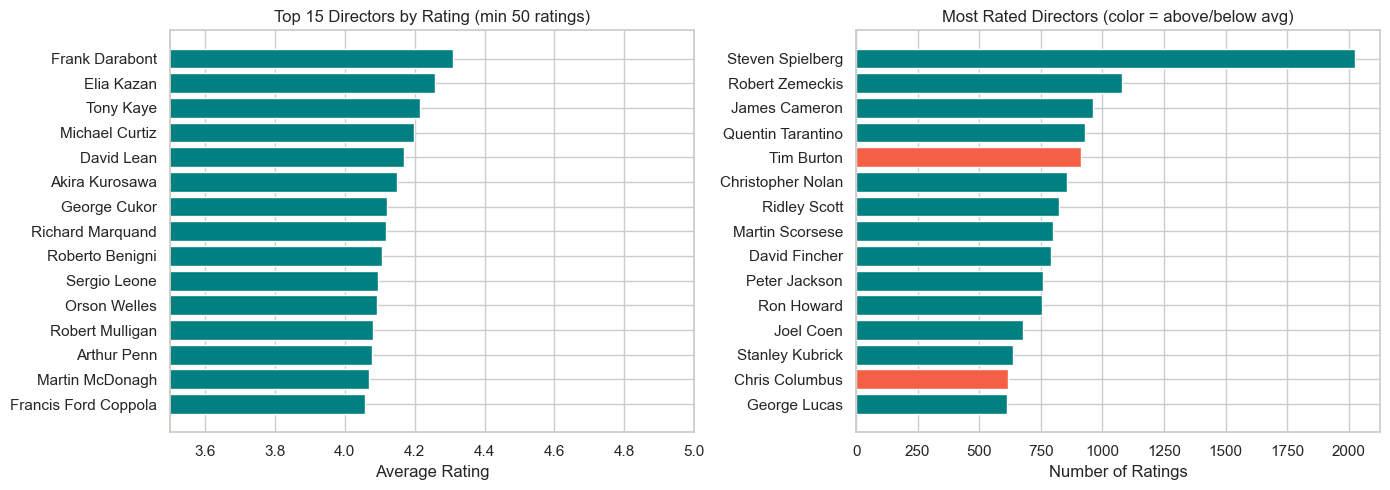


Total directors with 50+ ratings: 432


In [14]:
# Director statistics (min 50 ratings for reliability)
director_stats = df.groupby('director').agg(
    n_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    n_movies=('movieId', 'nunique')  # Fixed: use movieId instead of title
).reset_index()

# Filter directors with enough data
director_stats = director_stats[director_stats['n_ratings'] >= 50]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top rated directors
top_directors = director_stats.nlargest(15, 'avg_rating')
axes[0].barh(top_directors['director'], top_directors['avg_rating'], 
             color=PALETTE_5[0], edgecolor='white')
axes[0].axvline(x=df['rating'].mean(), color=PALETTE_5[2], linestyle='--', alpha=0.7)
axes[0].set_xlabel('Average Rating')
axes[0].set_title('Top 15 Directors by Rating (min 50 ratings)')
axes[0].invert_yaxis()
axes[0].set_xlim(3.5, 5)

# Most prolific directors
prolific_directors = director_stats.nlargest(15, 'n_ratings')
colors = [PALETTE_5[0] if r >= df['rating'].mean() else PALETTE_6[1] 
          for r in prolific_directors['avg_rating']]
axes[1].barh(prolific_directors['director'], prolific_directors['n_ratings'], 
             color=colors, edgecolor='white')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_title('Most Rated Directors (color = above/below avg)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nTotal directors with 50+ ratings: {len(director_stats)}")

### 6. Country & Language Analysis

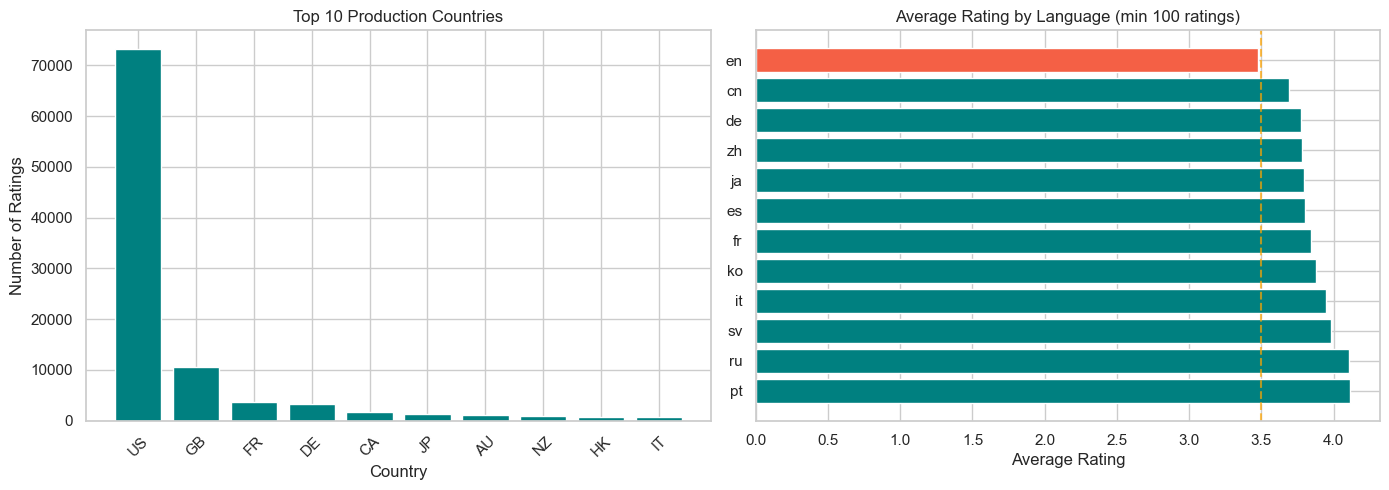


US productions: 73.0% | English language: 94.4%


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Country distribution
country_counts = df['country'].value_counts().head(10)
axes[0].bar(country_counts.index, country_counts.values, color=PALETTE_5[0], edgecolor='white')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_title('Top 10 Production Countries')
axes[0].tick_params(axis='x', rotation=45)

# Language and rating
lang_stats = df.groupby('original_language').agg(
    count=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()
lang_stats = lang_stats[lang_stats['count'] >= 100].sort_values('avg_rating', ascending=False)

colors = [PALETTE_5[0] if r >= df['rating'].mean() else PALETTE_6[1] for r in lang_stats['avg_rating']]
axes[1].barh(lang_stats['original_language'], lang_stats['avg_rating'], color=colors, edgecolor='white')
axes[1].axvline(x=df['rating'].mean(), color=PALETTE_5[2], linestyle='--', alpha=0.7)
axes[1].set_xlabel('Average Rating')
axes[1].set_title('Average Rating by Language (min 100 ratings)')

plt.tight_layout()
plt.show()

us_pct = (df['country'] == 'US').mean() * 100
en_pct = (df['original_language'] == 'en').mean() * 100
print(f"\nUS productions: {us_pct:.1f}% | English language: {en_pct:.1f}%")

### 7. Feature Correlations

Understanding which features predict ratings for the ML model.

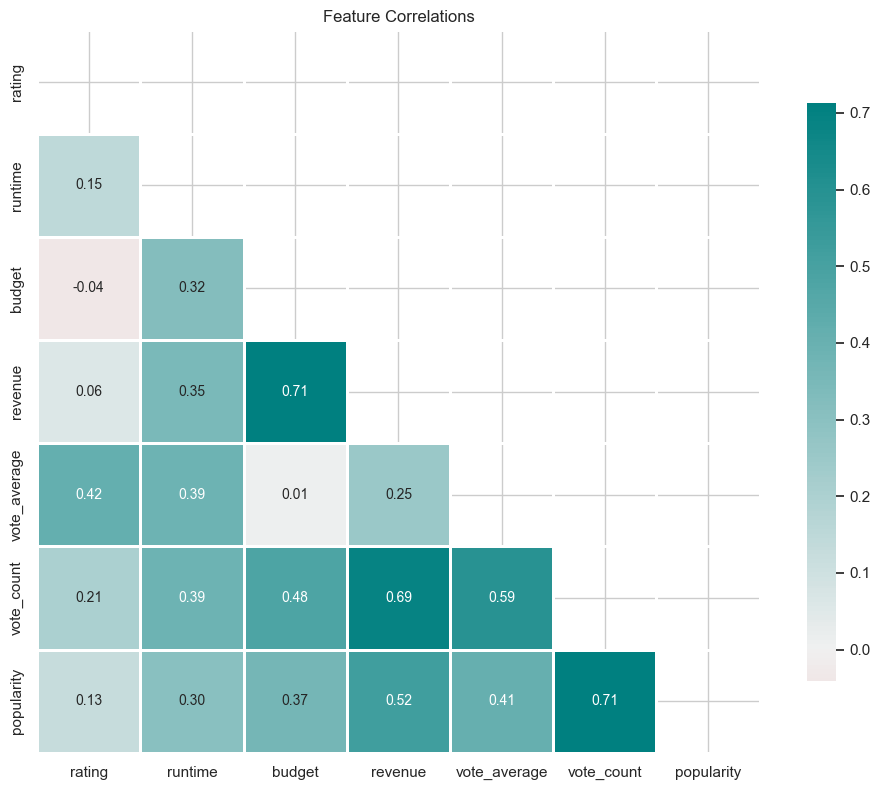


Correlations with Rating:
  vote_average: 0.416
  vote_count: 0.206
  runtime: 0.148
  popularity: 0.130
  revenue: 0.057
  budget: -0.041


In [16]:
# Numerical features correlation with rating
num_cols = ['rating', 'runtime', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap=heatmap_cmap,
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# Correlations with rating
rating_corrs = corr_matrix['rating'].drop('rating').sort_values(ascending=False)
print("\nCorrelations with Rating:")
for feat, corr in rating_corrs.items():
    print(f"  {feat}: {corr:.3f}")

### 8. Group Recommendation Insights

Key metrics for the slate optimizer.

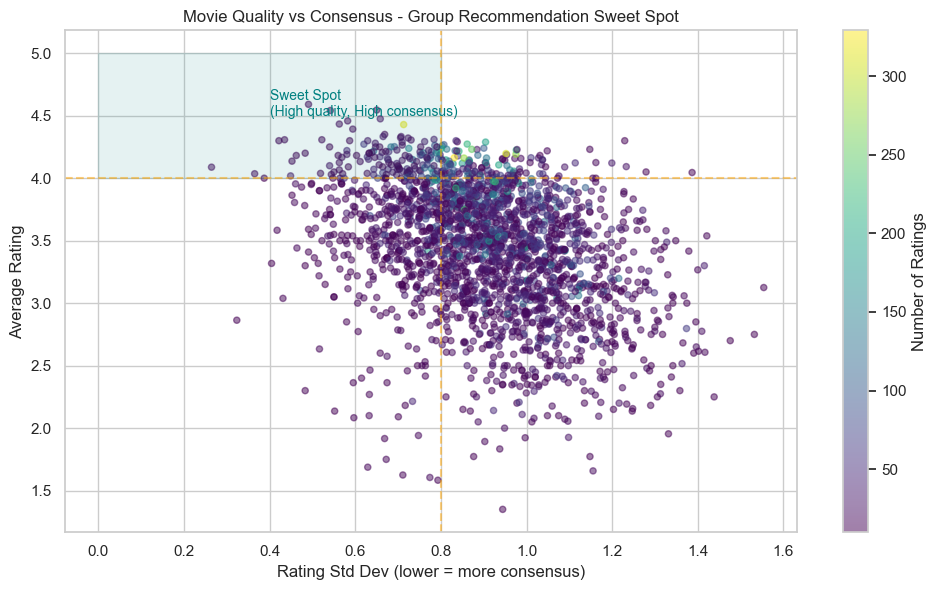


Sweet spot movies (avg ≥ 4.0, std ≤ 0.8): 143

Top 10 safe choices for groups:
                         title  avg_rating  std_rating  n_ratings
                Secrets & Lies    4.590909    0.490825         11
  Guess Who's Coming to Dinner    4.545455    0.650175         11
                Paths of Glory    4.541667    0.541812         12
     Streetcar Named Desire, A    4.475000    0.658447         20
     Celebration, The (Festen)    4.458333    0.582250         12
                           Ran    4.433333    0.562731         15
     Shawshank Redemption, The    4.429022    0.713019        317
               His Girl Friday    4.392857    0.594157         14
All Quiet on the Western Front    4.350000    0.668747         10
                  Hustler, The    4.333333    0.707107         18


In [17]:
# Movies with high average AND low variance = safe group choices
movie_stats_full = df.groupby('title').agg(
    n_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    min_rating=('rating', 'min'),
    max_rating=('rating', 'max')
).reset_index()

# Filter movies with enough ratings
movie_stats_full = movie_stats_full[movie_stats_full['n_ratings'] >= 10]

# Scatter: avg rating vs std (consensus)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(movie_stats_full['std_rating'], movie_stats_full['avg_rating'],
                      c=movie_stats_full['n_ratings'], cmap='viridis', 
                      alpha=0.5, s=20)
plt.colorbar(scatter, label='Number of Ratings')
plt.xlabel('Rating Std Dev (lower = more consensus)')
plt.ylabel('Average Rating')
plt.title('Movie Quality vs Consensus - Group Recommendation Sweet Spot')

# Highlight sweet spot (high avg, low std)
sweet_spot = movie_stats_full[(movie_stats_full['avg_rating'] >= 4.0) & 
                               (movie_stats_full['std_rating'] <= 0.8)]
plt.axhline(y=4.0, color=PALETTE_5[2], linestyle='--', alpha=0.5)
plt.axvline(x=0.8, color=PALETTE_5[2], linestyle='--', alpha=0.5)
plt.fill_between([0, 0.8], [4.0, 4.0], [5, 5], alpha=0.1, color=PALETTE_5[0])
plt.annotate('Sweet Spot\n(High quality, High consensus)', 
             xy=(0.4, 4.5), fontsize=10, color=PALETTE_5[0])

plt.tight_layout()
plt.show()

print(f"\nSweet spot movies (avg ≥ 4.0, std ≤ 0.8): {len(sweet_spot)}")
print(f"\nTop 10 safe choices for groups:")
print(sweet_spot.nlargest(10, 'avg_rating')[['title', 'avg_rating', 'std_rating', 'n_ratings']].to_string(index=False))

In [18]:
# Genre diversity analysis for slate optimization
all_genres = df_exploded['genre_list'].unique()
print(f"Total unique genres: {len(all_genres)}")
print(f"\nGenres: {', '.join(sorted(all_genres))}")

# Genre co-occurrence for diversity calculation
genre_pairs = []
for genres in df['genres'].str.split('|'):
    if len(genres) > 1:
        for i, g1 in enumerate(genres):
            for g2 in genres[i+1:]:
                genre_pairs.append(tuple(sorted([g1, g2])))

pair_counts = pd.Series(genre_pairs).value_counts().head(10)
print(f"\nMost common genre combinations:")
for pair, count in pair_counts.items():
    print(f"  {pair[0]} + {pair[1]}: {count:,}")

Total unique genres: 20

Genres: (no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

Most common genre combinations:
  Action + Adventure: 13,769
  Action + Thriller: 13,298
  Action + Sci-Fi: 10,794
  Comedy + Romance: 10,732
  Drama + Thriller: 10,087
  Comedy + Drama: 9,665
  Drama + Romance: 9,606
  Crime + Thriller: 8,928
  Crime + Drama: 8,413
  Adventure + Sci-Fi: 7,929


### EDA Summary

**Key findings for Group Recommendation System:**

1. **Rating Distribution**: Skewed positive (mean ~3.5), 70%+ ratings are ≥3.5

2. **User Diversity**: Wide range of user leniency (avg ratings 2.0-5.0) - critical for group optimization

3. **Predictive Features**: TMDB vote_average has highest correlation with our ratings - useful feature

4. **Genre Insights**: Drama, Comedy most common; Film-Noir, Documentary highest rated but niche

5. **Consensus Movies**: Identified "sweet spot" movies with high avg AND low std - ideal for groups

6. **Director Effect**: Strong director signal - some directors consistently produce high-rated films

7. **US Dominance**: ~80% US productions, but foreign films often rate higher

In [19]:
print("="*50)
print("FINAL DATASET STATISTICS")
print("="*50)
print(f"Total ratings: {len(df):,}")
print(f"Unique users: {df['userId'].nunique():,}")
print(f"Unique movies: {df['movieId'].nunique():,}")  # Fixed: use movieId instead of title
print(f"Unique directors: {df['director'].nunique():,}")
print(f"Unique genres: {len(all_genres)}")
print(f"\nRating statistics:")
print(f"  Mean: {df['rating'].mean():.2f}")
print(f"  Median: {df['rating'].median():.1f}")
print(f"  Std: {df['rating'].std():.2f}")
print(f"\nData saved to: {output_path}")

FINAL DATASET STATISTICS
Total ratings: 100,357
Unique users: 610
Unique movies: 9,514
Unique directors: 3,922
Unique genres: 20

Rating statistics:
  Mean: 3.50
  Median: 3.5
  Std: 1.04

Data saved to: ../data/processed/ratings_cleaned.csv


## User discovery and user group creation for testing

Run the following script:

```bash
uv run ./src/discover_users_diverse.py
```

This will create the file `/data/processed/discovered_users_diverse.json`